In [1]:
import os
import numpy as np
from os import path
from urllib.request import urlretrieve
import sklearn
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.tokenize import sent_tokenize
import unidecode
EPSILON = 1e-15

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/dalkio/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### I - Loading and visualizing pre-trained embeddings

To measure smilariy between vectors, we often use the cosine similarity.
(https://en.wikipedia.org/wiki/Cosine_similarity)
$cosine\_similarity(w_1, w_2) = \Large \frac{\langle w_1, w_2 \rangle}{||w_1|| \cdot ||w_2||} = \frac{w_1^T \cdot w_2}{||w_1|| \cdot ||w_2||}$

$w_1$ and $w_2$ are $2$ word vector embeddings.

It is a measure of how aligned $w_1$ and $w_2$ are.

In [3]:
class PretrainedEmbeddings():
    def __init__(self, language, embeddings):
        self.vec_file = None
        if language == 'en':
            if embeddings == 'glove':
                self.vec_file = 'glove_100k.en.vec'
            elif embeddings == 'ft':
                self.vec_file = 'ft_300k.en.vec'
        elif language == 'fr':
            if embeddings == 'glove':
                print('No GloVe french embeddings!')
                return None
            elif embeddings == 'ft':
                self.vec_file = 'ft_50k.fr.vec'
        self.language = language
        self.url = "https://github.com/ECE-Deep-Learning/courses_labs/releases/download/0.1/" + self.vec_file
        self.file_location = os.path.join('data', self.vec_file)
        self.embeddings_index = None
        self.embeddings_index_inversed = None
        self.embeddings_vectors = None
        self.voc_size = None
        self.dim = None
    
    @staticmethod
    def _normalize(array):
        return array / np.linalg.norm(array, axis=-1, keepdims=True)
        
    def download(self):
        if not path.exists(self.file_location):
            print('Downloading from %s to %s...' % (self.url, self.file_location))
            urlretrieve(self.url, self.file_location)
            print('Downloaded embeddings')        
         
    # Note that you can choose to normalize directly the embeddings 
    # to make the cosine similarity computation easier afterward
    def load(self, normalize=False):
        self.embeddings_index, self.embeddings_index_inversed = {}, {}
        self.embeddings_vectors = []
        file = open(self.file_location)
        header = next(file)
        self.voc_size, self.dim = [int(token) for token in header.split()]
        print('Vocabulary size: {0}\nEmbeddings dimension: {1}'.format(self.voc_size, self.dim))
        print('Loading embeddings in memory...')
        for idx, line in enumerate(file):
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            self.embeddings_index[word] = idx
            self.embeddings_index_inversed[idx] = word
            self.embeddings_vectors.append(vector)
        self.embeddings_vectors = np.asarray(self.embeddings_vectors)
        print('Embeddings loaded')
        if normalize:
            self.embeddings_vectors = self._normalize(self.embeddings_vectors)
            print('Embeddings normalized')
        file.close()
        
    def word_to_vec(self, word):
        idx = self.embeddings_index.get(word)
        return self.embeddings_vectors[idx] if idx else None
    
    def vec_to_word(self, vec):
        vec /= np.linalg.norm(vec)
        cosines = np.dot(self.embeddings_vectors, vec)
        most_similar_index = np.argsort(cosines)[::-1][0]
        return self.embeddings_index_inversed[most_similar_index]

    def most_similar(self, query, top=10):
        query = str(query).split()
        query_vec = np.zeros(self.dim)
        for token in query:
            token_vec = self.word_to_vec(token)
            if token_vec is not None:
                query_vec += token_vec
        if np.all(query_vec == 0):
            print('No existing words found!')
            return None
        query_vec /= np.linalg.norm(query_vec)
        cosines = np.dot(self.embeddings_vectors, query_vec)
        most_similar_indexes = np.argsort(cosines)[::-1][:top]
        return [(self.embeddings_index_inversed[idx], cosines[idx]) 
                for idx in most_similar_indexes]
    
    def project_and_visualize(self, sample=1000):
        embeddings_tsne = TSNE(perplexity=30).fit_transform(self.embeddings_vectors[:sample])
        plt.figure(figsize=(40, 40))
        axis = plt.gca()
        np.set_printoptions(suppress=True)
        plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], marker=".", s=1)
        for idx in range(sample):
            plt.annotate(
                self.embeddings_index_inversed[idx],
                xy=(embeddings_tsne[idx, 0], embeddings_tsne[idx, 1]),
                xytext=(0, 0), textcoords='offset points'
            )

In [4]:
pretrained_embeddings = PretrainedEmbeddings(language='en', embeddings='glove')
pretrained_embeddings.download()
pretrained_embeddings.load(normalize=True)

Downloaded embeddings
Vocabulary size: 100000
Embeddings dimension: 100
Loading embeddings in memory...
Embeddings loaded
Embeddings normalized


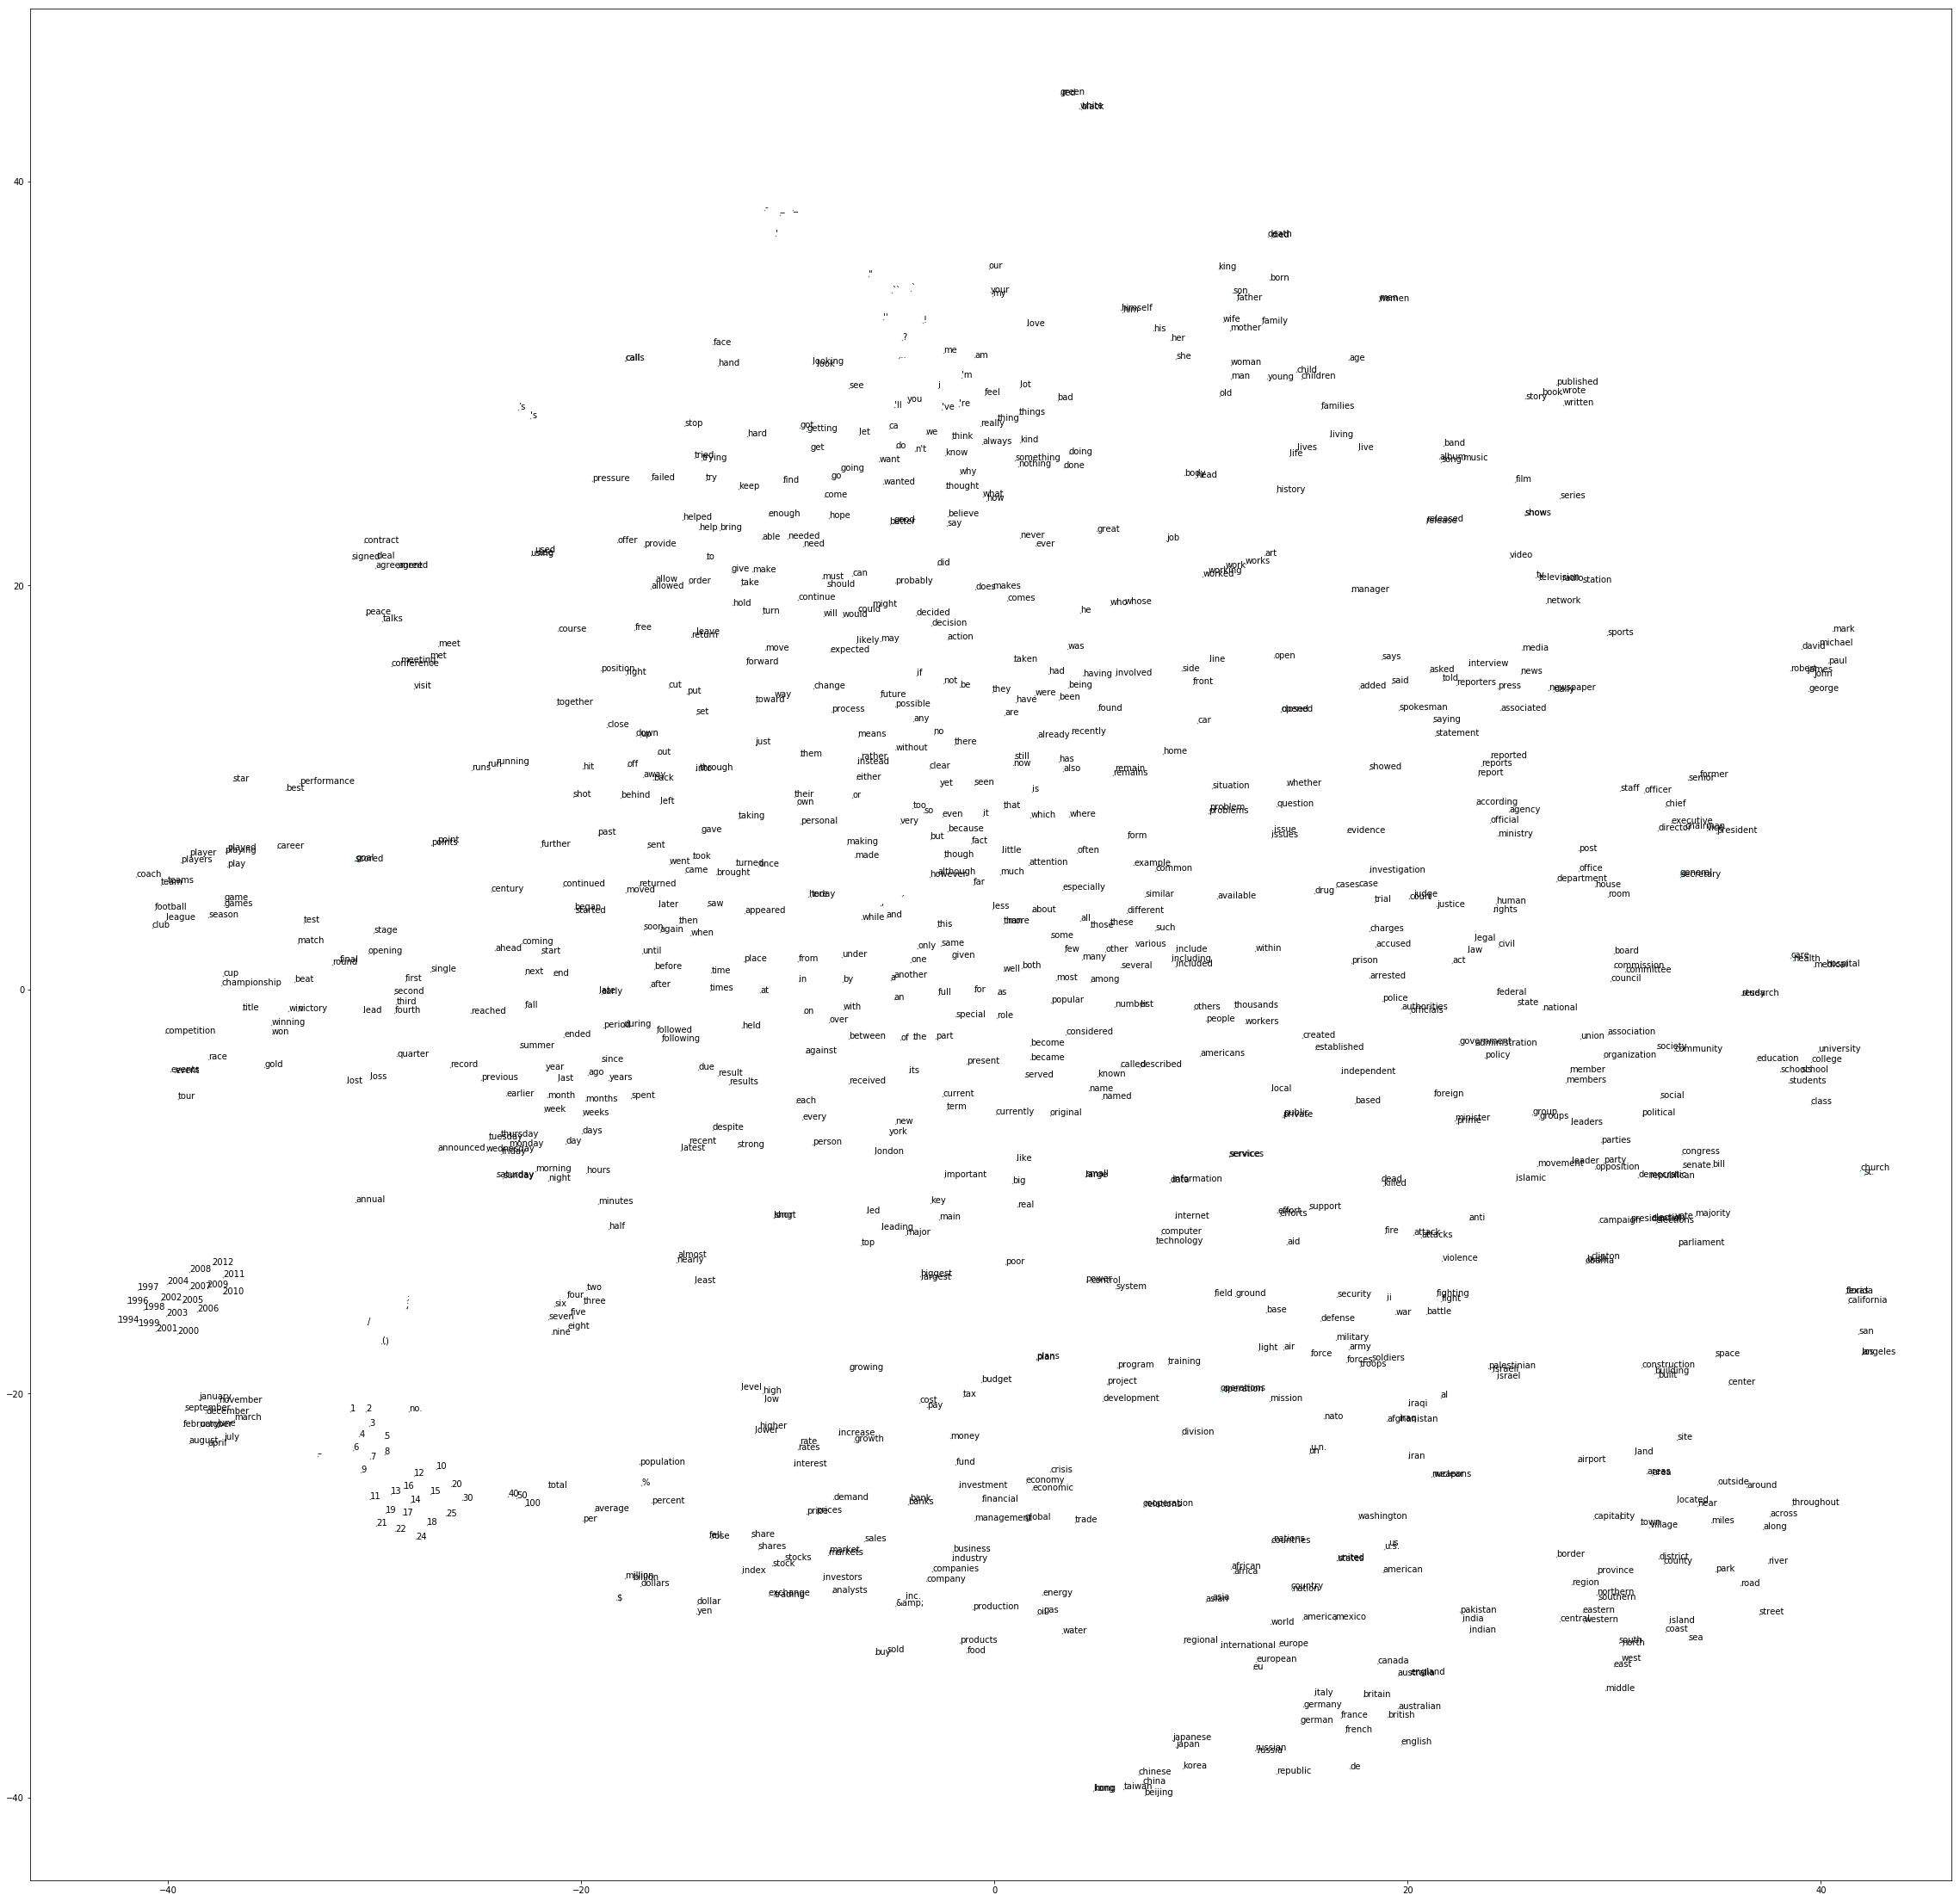

In [5]:
pretrained_embeddings.project_and_visualize()

In [6]:
pretrained_embeddings.most_similar('french city')

[('french', 0.8304091203892022),
 ('city', 0.8304090005721323),
 ('where', 0.7353211721490712),
 ('town', 0.7246657292028251),
 ('paris', 0.7235699668246216),
 ('part', 0.7230180884725408),
 ('the', 0.7170442053640332),
 ('southern', 0.7099041921455281),
 ('british', 0.7083429220375311),
 ('western', 0.6970235555970169)]

### II - Language modelling

#### Sampling random text from the model

First part of language modelling will be about predicting the next character of a finite sequence of characters of size $k$.

Recursively generate one character at a time:

Your model outputs the probability distribution $p_{\theta}(c_{n} | c_{n-1}, \ldots, c_{n-k})$

Using this probability distribution, a predicted character $c_{n}$ will be sampled. The temperature parameter makes it possible to remove additional entropy (bias) into the parameterized multinoulli distribution of the output of the model.

Then use your prediction $c_{n}$ to compute $c_{n+1}$. Your model outputs:
$p_{\theta}(c_{n+1} | $<span style="color:red">$c_{n}$</span>$, \ldots, c_{n-k+1})$

In [7]:
class LanguageModel():
    def __init__(self):
        self.corpus_path = None
        self.corpus = None
    
    def load_data(self, corpus_path):
        self.corpus_path = os.path.join('data', corpus_path)
        file = open(self.corpus_path)
        self.corpus = unidecode.unidecode(file.read().lower().replace("\n", " "))
        print('Corpus length: {0} characters'.format(len(self.corpus)))
        file.close()
    
    def get_contiguous_sample(self, size):
        index = np.random.randint(1, len(self.corpus) - size)
        return self.corpus[index:index+size]

In [8]:
sample_size = 500

language_model = LanguageModel()
language_model.load_data('rousseau.txt')
print('Sample of {0} characters:\n{1}'.format(
    sample_size, language_model.get_contiguous_sample(sample_size)
))

Corpus length: 1017501 characters
Sample of 500 characters:
idee: si-tot que vous en figurez un dans votre esprit, c'est un tel triangle et non pas un autre, et vous ne pouvez eviter d'en rendre les lignes sensibles ou le plan colore. il faut donc enoncer des propositions, il faut donc parler pour avoir des idees generales: car si-tot que l'imagination s'arrete, l'esprit ne marche plus qu'a l'aide du discours. si donc les premiers inventeurs n'ont pu donner des noms qu'aux idees qu'ils avoient deja, il s'ensuit que les premiers substantifs n'ont jamais p


### II - a) Character-based language modelling

#### Measuring per-character perplexity

To measure the quality of a language model we usually use the perplexity.
(https://en.wikipedia.org/wiki/Perplexity)

Here is how it is defined:

$$perplexity_\theta = 2^{-\frac{1}{n} \sum_{i=1}^{n} log_2 (p_\theta(c_i)^T\cdot y_i)}$$
$p_\theta(c_i)$ is your predicted column vector of probabilities over the possible next characters for the $i^{th}$ sequence.
$y_i$ is the one-hot encoding vector of the answer: the next character of the $i^{th}$ sequence.

You just compute the average negative loglikelihood like you have done previously, only using a log2 logarithm. Then just perform a base $2$ exponentiation of the quantity just computed.

In [9]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

class CharLanguageModel(LanguageModel):
    def __init__(self):
        super(LanguageModel, self).__init__()
        self.char_index = None
        self.char_index_inversed = None
        self.vocabulary_size = None
        self.max_length_sequence = None
        self.X = None
        self.y = None
        self.model = None
    
    def extract_vocabulary(self):
        chars = sorted(set(self.corpus))
        self.char_index = dict((c, i) for i, c in enumerate(chars))
        self.char_index_inversed = dict((i, c) for i, c in enumerate(chars))
        self.vocabulary_size = len(self.char_index)
        print('Vocabulary size: {0}'.format(self.vocabulary_size))
        
    def plot_vocabulary_distribution(self):
        counter = Counter(self.corpus)
        chars, counts = zip(*counter.most_common())
        indices = np.arange(len(counts))
        plt.figure(figsize=(16, 5))
        plt.bar(indices, counts, 0.8)
        plt.xticks(indices, chars)
        
    """
    Convert X and y into one-hot encoded matrices
    
    Importante note: if the sequence length if smaller than max_length_sequence, 
    we pad the input with zeros vectors at the beginning of the one-hot encoded matrix
    """
    def _one_hot_encoding(self, X, y):
        X_one_hot = np.zeros(
            (len(X), self.max_length_sequence, self.vocabulary_size), 
            dtype=np.float32
        )
        y_one_hot = np.zeros(
            (len(X), self.vocabulary_size), 
            dtype=np.float32
        )
        for i, sequence in enumerate(X):
            shift = self.max_length_sequence - len(sequence)
            for j, char in enumerate(sequence):
                X_one_hot[i, shift+j, self.char_index[char]] = 1
            y_one_hot[i, self.char_index[y[i]]] = 1
              
        return X_one_hot, y_one_hot 
    
    """
    The matrices X and y are created in this method
    It consists of sampling sentences in the corpus as training vectors with the next character as target
    """
    def build_dataset(self, 
                      max_length_sequence=40, min_length_sentence=5, max_length_sentence=200, 
                      step=3):
        self.X, self.y = [], []
        
        sentences = sent_tokenize(self.corpus)
        sentences = filter(
            lambda x: len(x) >= min_length_sentence and len(x) <= max_length_sentence, 
            sentences
        )
        for sentence in sentences:
            for i in range(0, max(len(sentence) - max_length_sequence, 1), step):
                last_index = min(i+max_length_sequence, i+len(sentence)-1)
                self.X.append(sentence[i:last_index])
                self.y.append(sentence[last_index])

        self.max_length_sequence = max_length_sequence
        self.X, self.y = sklearn.utils.shuffle(self.X, self.y)
        print('Number of training sequences: {0}'.format(len(self.X)))
        self.X, self.y = self._one_hot_encoding(self.X, self.y)
        print('X shape: {0}\ny shape: {1}'.format(self.X.shape, self.y.shape))
        
    """
    Define, compile, and fit a Keras model on (self.X, self.y)
    It should be composed of :
        - one recurrent LSTM layer projecting into hidden_size dimensions
        - one Dense layer with a softmax activation projecting into vocabulary_size dimensions
    """
    def train(self, hidden_size=128, batch_size=128, epochs=10):
        self.model = Sequential()
        self.model.add(
            LSTM(hidden_size, input_shape=(
                self.max_length_sequence, self.vocabulary_size
            ))
        )
        self.model.add(
            Dense(self.vocabulary_size, activation='softmax')
        )

        optimizer = Adam()
        self.model.compile(
            optimizer=optimizer, 
            loss='categorical_crossentropy',
        )
        self.model.fit(
            self.X, self.y, validation_split=0.1, 
            batch_size=batch_size, epochs=epochs
        )
    
    """
    Return the prediction of our model, meaning the next token given an input sequence
    
    If preprocessed is specified as True, we consider X as an array of strings and we will transform
    it to a one-hot encoded matrix
    Importante note: if the sequence length if smaller than max_length_sequence, 
    we pad the input with zeros vectors at the beginning of the one-hot encoded matrix
    
    If preprocessed is specified as False, we apply the model predict on X as it is
    """
    def predict(self, X, verbose=1, preprocessed=True):
        if not preprocessed:
            X_one_hot = np.zeros(
                (len(X), self.max_length_sequence, self.vocabulary_size), dtype=np.float32
            )
            for i, sequence in enumerate(X):
                shift = self.max_length_sequence - len(sequence)
                for j, char in enumerate(sequence):
                    X_one_hot[i, shift+j, self.char_index[char]] = 1
        else:
            X_one_hot = X
        return self.model.predict(X_one_hot, verbose=verbose)
    
    # Perplexity metric used to appreciate the performance of our model
    def perplexity(self, y_true, y_pred):
        likelihoods = np.sum(y_pred * y_true, axis=1)
        return 2 ** -np.mean(np.log2(likelihoods + EPSILON))
    
    """
    Sample the next character according to the predictions.
    
    Use a lower temperature to force the model to output more
    confident predictions: more peaky distribution.
    """
    def _sample_next_char(self, preds, temperature=1.0):
        preds = np.asarray(preds).astype('float64')
        preds = np.log(preds + EPSILON) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds + EPSILON)
        probs = np.random.multinomial(1, preds, size=1)
        return np.argmax(probs)
    
    def generate_text(self, seed_string, length=300, temperature=1.0):
        if self.model is None:
            print('The language model has not been trained yet!')
            return None
        generated = seed_string
        prefix = seed_string
        for i in range(length):
            predictions = np.ravel(self.predict([prefix], verbose=0, preprocessed=False))
            next_index = self._sample_next_char(predictions, temperature)
            next_char = self.char_index_inversed[next_index]
            generated += next_char
            prefix = prefix[1:] + next_char
        return generated

Using TensorFlow backend.


In [10]:
language_model = CharLanguageModel()
language_model.load_data('rousseau.txt')

Corpus length: 1017501 characters


In [11]:
language_model.extract_vocabulary()
language_model.char_index

Vocabulary size: 45


{' ': 0,
 '!': 1,
 "'": 2,
 ',': 3,
 '-': 4,
 '.': 5,
 '0': 6,
 '1': 7,
 '2': 8,
 '3': 9,
 '4': 10,
 '5': 11,
 '6': 12,
 '7': 13,
 '8': 14,
 '9': 15,
 ':': 16,
 ';': 17,
 '?': 18,
 'a': 19,
 'b': 20,
 'c': 21,
 'd': 22,
 'e': 23,
 'f': 24,
 'g': 25,
 'h': 26,
 'i': 27,
 'j': 28,
 'k': 29,
 'l': 30,
 'm': 31,
 'n': 32,
 'o': 33,
 'p': 34,
 'q': 35,
 'r': 36,
 's': 37,
 't': 38,
 'u': 39,
 'v': 40,
 'w': 41,
 'x': 42,
 'y': 43,
 'z': 44}

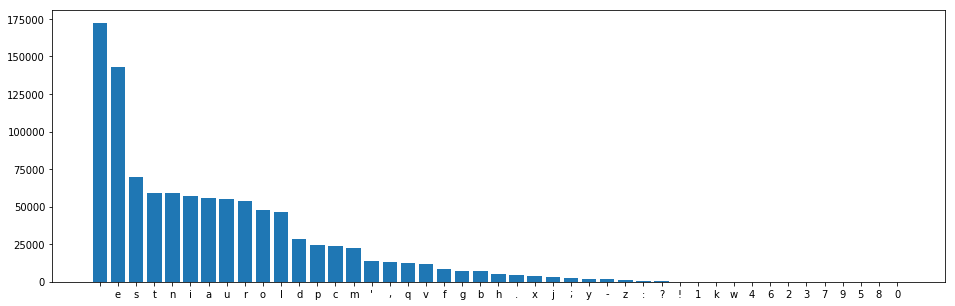

In [12]:
language_model.plot_vocabulary_distribution()

In [13]:
language_model.build_dataset()

Number of training sequences: 85455
X shape: (85455, 40, 45)
y shape: (85455, 45)


In [14]:
epochs = 5
language_model.train(epochs=epochs)
print('Perplexity after {0} epochs: {1}'.format(
    epochs, language_model.perplexity(language_model.y, language_model.model.predict(language_model.X))
))

Train on 76909 samples, validate on 8546 samples
Epoch 1/5
76909/76909 [==============================] - 31s 398us/step - loss: 2.6181 - val_loss: 2.2852
Epoch 2/5
76909/76909 [==============================] - 31s 401us/step - loss: 2.1964 - val_loss: 2.1150
Epoch 3/5
76909/76909 [==============================] - 27s 353us/step - loss: 2.0750 - val_loss: 2.0146
Epoch 4/5
76909/76909 [==============================] - 29s 376us/step - loss: 1.9946 - val_loss: 1.9470
Epoch 5/5
76909/76909 [==============================] - 27s 357us/step - loss: 1.9321 - val_loss: 1.8957
Perplexity after 5 epochs: 6.633784618557662


In [15]:
language_model.generate_text("l'etat n'est pas au-dessus de la loi", temperature=0.25)

"l'etat n'est pas au-dessus de la loire de la sait de les partier l'est aus de les conter l'autre de sent le sait a la sout a la traine de le pour le forte de le corment a par de la prent de la sour de la sour de les conter et se seut la sont a l'eur de le preste de les contre de les parte ne la sout a le serait de la cetre de contre d"

In [16]:
language_model.generate_text("la republique", temperature=0.25)

'la republique de la prait de les partion a la sout de le parte de les comment et la joune de le parte de le reraine de la destit en la sout de les contre de les farte de les conter la sout le serit de les desure de la parte de les conser de la roine de la sant de la souvert de la sout de les raine de la contre d'

### II - b) Word-based language modelling

In [18]:
from spacy.lang.fr import French
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

class WordLanguageModel(LanguageModel):
    def __init__(self):
        super(LanguageModel, self).__init__()
        self.pretrained_embeddings = PretrainedEmbeddings(language='fr', embeddings='ft')
        self.pretrained_embeddings.download()
        self.pretrained_embeddings.load()
        self.parser = None
        self.word_index = None
        self.word_index_inversed = None
        self.vocabulary_size = None
        self.max_length_sequence = None
        self.tokens = None
        self.X = None
        self.y = None
        self.model = None
        
    def extract_vocabulary(self, max_vocabulary=1500000):
        self.parser = French(max_length=max_vocabulary)
        self.tokens = [token.orth_ for token in self.parser(self.corpus) if token.is_alpha]
        unique_tokens = set(self.tokens)
        self.word_index = dict((w, i) for i, w in enumerate(unique_tokens))
        self.word_index_inversed = dict((i, w) for i, w in enumerate(unique_tokens))
        self.vocabulary_size = len(self.word_index)
        print('Vocabulary size: {0}'.format(self.vocabulary_size))
        
    """
    Convert X and y into embedded matrices
    Hint: use the self.pretrained_embeddings.word_to_vec method for each token found
    
    Importante notes: 
    - if the sequence length if smaller than max_length_sequence, 
    we pad the input with zeros vectors at the beginning of the embedded matrix
    - if a word is not found in self.pretrained_embeddings.word_to_vec then word should be
    mapped to a vector of zeros instead
    """
    def _token_embedding(self, X, y):
        X_embedding = np.zeros(
            (len(X), self.max_length_sequence, self.pretrained_embeddings.dim), 
            dtype=np.float32
        )       
        y_one_hot = np.zeros(
            (len(X), self.vocabulary_size), 
            dtype=np.float32
        )
        for i, sequence in enumerate(X):
            shift = self.max_length_sequence - len(sequence)
            for j, word in enumerate(sequence):
                if self.pretrained_embeddings.word_to_vec(word) is not None:
                    X_embedding[i, shift+j, :] = self.pretrained_embeddings.word_to_vec(word)
            y_one_hot[i, self.word_index[y[i]]] = 1
        return X_embedding, y_one_hot
        
    def build_dataset(self, max_length_sequence=40, step=3):
        self.X, self.y = [], []
        for i in range(0, len(self.tokens) - max_length_sequence, step):
            self.X.append(self.tokens[i:i+max_length_sequence])
            self.y.append(self.tokens[i+max_length_sequence])
        self.max_length_sequence = max_length_sequence
        self.X, self.y = sklearn.utils.shuffle(self.X, self.y)
        print('Number of training sequences: {0}'.format(len(self.X)))
        self.X, self.y = self._token_embedding(self.X, self.y)
        print('X shape: {0}\ny shape: {1}'.format(self.X.shape, self.y.shape))
        
    """
    Define, compile, and fit a Keras model on (self.X, self.y)
    It should be composed of :
        - one or many recurrent LSTM layers projecting into hidden_size dimensions
        - one Dense layer with a relu activation projecting into hidden_size dimensions
        - one Dense layer with a softmax activation projecting into vocabulary_size dimensions
    """
    def train(self, hidden_size=128, batch_size=128, epochs=10):
        self.model = Sequential()
        self.model.add(
            LSTM(hidden_size, return_sequences=True, input_shape=(
                self.max_length_sequence, self.pretrained_embeddings.dim
            ))
        )
        self.model.add(
            LSTM(hidden_size)
        )
        self.model.add(
            Dense(hidden_size, activation='relu')
        )
        self.model.add(
            Dense(self.vocabulary_size, activation='softmax')
        )
        optimizer = Adam()
        self.model.compile(
            optimizer=optimizer, 
            loss='categorical_crossentropy',
        )
        self.model.fit(
            self.X, self.y, validation_split=0.1, 
            batch_size=batch_size, epochs=epochs
        )
        
    """
    Return the prediction of our model, meaning the next token given an input sequence
    
    If preprocessed is specified as True, we consider X as an array of strings and we will transform
    it to an embedded matrix using self.pretrained_embeddings.word_to_vec
    Importante note: if the sequence length if smaller than max_length_sequence, 
    we pad the input with zeros vectors at the beginning of the embedded matrix
    
    If preprocessed is specified as False, we apply the model predict on X as it is
    """
    def predict(self, X, verbose=1, preprocessed=True):
        if not preprocessed:
            X_embedding = np.zeros(
                (len(X), self.max_length_sequence, self.pretrained_embeddings.dim), 
                dtype=np.float32
            )
            for i, sequence in enumerate(X):
                shift = self.max_length_sequence - len(sequence)
                for j, word in enumerate(sequence):
                    if self.pretrained_embeddings.word_to_vec(word) is not None:
                        X_embedding[i, shift+j, :] = self.pretrained_embeddings.word_to_vec(word)
        else:
            X_embedding = X
        return self.model.predict(X_embedding, verbose=verbose)
    
    """
    Sample the next word according to the predictions.
    
    Use a lower temperature to force the model to output more
    confident predictions: more peaky distribution.
    """
    def _sample_next_word(self, preds, temperature=1.0):
        preds = np.asarray(preds).astype('float64')
        preds = np.log(preds + EPSILON) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds + EPSILON)
        probs = np.random.multinomial(1, preds, size=1)
        return np.argmax(probs)
    
    def generate_text(self, seed_string, length=50, temperature=1.0):
        if self.model is None:
            print('The language model has not been trained yet!')
            return None
        seed_tokens = [token.orth_ for token in self.parser(seed_string) if token.is_alpha]
        prefix = seed_tokens
        generated = seed_tokens
        for i in range(length):
            predictions = np.ravel(self.predict([prefix], verbose=0, preprocessed=False))
            next_index = self._sample_next_word(predictions)
            next_word = self.word_index_inversed[next_index]
            generated += [next_word]
            prefix = prefix[1:] + [next_word]
        return " ".join(generated)

In [19]:
language_model = WordLanguageModel()
language_model.load_data('rousseau.txt')

Downloaded embeddings
Vocabulary size: 50131
Embeddings dimension: 300
Loading embeddings in memory...
Embeddings loaded
Corpus length: 1017501 characters


In [20]:
language_model.extract_vocabulary()

Vocabulary size: 12097


In [21]:
language_model.build_dataset()

Number of training sequences: 57326
X shape: (57326, 40, 300)
y shape: (57326, 12097)


In [22]:
epochs = 5
language_model.train(epochs=epochs)

Train on 51593 samples, validate on 5733 samples
Epoch 1/5
51593/51593 [==============================] - 82s 2ms/step - loss: 6.9017 - val_loss: 6.7273
Epoch 2/5
51593/51593 [==============================] - 72s 1ms/step - loss: 6.4726 - val_loss: 6.7044
Epoch 3/5
51593/51593 [==============================] - 67s 1ms/step - loss: 6.3740 - val_loss: 6.6899
Epoch 4/5
51593/51593 [==============================] - 67s 1ms/step - loss: 6.2913 - val_loss: 6.6779
Epoch 5/5
51593/51593 [==============================] - 67s 1ms/step - loss: 6.2290 - val_loss: 6.6269


In [23]:
language_model.generate_text("un état ne saurait réussir à", temperature=0.5)

'un état ne saurait réussir à resoudre detachant sont de rien foible dans aller elle on une penetrer il ses son peuples part ajoute les traitent par il apprenez une premier bien laisse le spectacle selon a boivent la ais precisement la sens la mort les moeurs les sophismes ainsi elle sauf la societe comme de'

In [24]:
language_model.generate_text("la république ne doit pas", temperature=1)

'la république ne doit pas ce plus je seroit plus nos sedentaire tout liberte de de rend timidite guerre il de faute faits pour accident mais qui est moins noire du faix de ainsi depuis sait etoient bientot renvoie la sans sen seroit corruption de car des etat le coeur ta egypte pas les recueillir'

### III - Supervised text classification

In [25]:
from sklearn.datasets import fetch_20newsgroups
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

#### 20 Newsgroups Dataset

The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups

In this third part, we will:
- Train a simple network to learn embeddings on a classification task
- Use pre-trained embeddings like GloVe or FastText and see the difference
- Train a recurrent neural network to handle the text structure

However keep in mind:
- We are here to learn deep learning methods for NLP tasks, but simple sparse TF-IDF bigrams features without any embedding or Logistic Regression are often competitive in small to medium datasets for text classification.

### III - a) Load, handle, and preprocess the data

In [26]:
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

In [27]:
print("sklearn object type : {}".format(type(newsgroups_train)))
print("sklearn object keys :")
for k in newsgroups_train:
    print(k)

sklearn object type : <class 'sklearn.utils.Bunch'>
sklearn object keys :
data
filenames
target_names
target
DESCR


In [28]:
print("Classes to predict : {}".format(os.linesep.join(newsgroups_train['target_names'])))
print()
print("Integer mapped-classes to predict :")
print(newsgroups_train['target'])

Classes to predict : alt.atheism
comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x
misc.forsale
rec.autos
rec.motorcycles
rec.sport.baseball
rec.sport.hockey
sci.crypt
sci.electronics
sci.med
sci.space
soc.religion.christian
talk.politics.guns
talk.politics.mideast
talk.politics.misc
talk.religion.misc

Integer mapped-classes to predict :
[7 4 4 ... 3 1 8]


In [29]:
class_int_str = dict(
    zip(range(len(newsgroups_train['target_names'])), newsgroups_train['target_names'])
)

In [30]:
class_int_str

{0: 'alt.atheism',
 1: 'comp.graphics',
 2: 'comp.os.ms-windows.misc',
 3: 'comp.sys.ibm.pc.hardware',
 4: 'comp.sys.mac.hardware',
 5: 'comp.windows.x',
 6: 'misc.forsale',
 7: 'rec.autos',
 8: 'rec.motorcycles',
 9: 'rec.sport.baseball',
 10: 'rec.sport.hockey',
 11: 'sci.crypt',
 12: 'sci.electronics',
 13: 'sci.med',
 14: 'sci.space',
 15: 'soc.religion.christian',
 16: 'talk.politics.guns',
 17: 'talk.politics.mideast',
 18: 'talk.politics.misc',
 19: 'talk.religion.misc'}

In [31]:
print("Example of document in dataset:", os.linesep)
sample_idx = np.random.randint(len(newsgroups_train["data"]))
print(newsgroups_train["data"][sample_idx])
sample_idx_class = class_int_str[newsgroups_train["target"][sample_idx]]
print("Example class to predict : {}".format(sample_idx_class))

Example of document in dataset: 

From: moseley@u.washington.edu (Steve L. Moseley)
Subject: Re: Observation re: helmets
Organization: Microbial Pathogenesis and Motorcycle Maintenance
Lines: 20
Distribution: world
NNTP-Posting-Host: microb0.biostat.washington.edu

In article <1qk5oi$d0i@sixgun.East.Sun.COM>
 egreen@east.sun.com (Ed Green - Pixel Cruncher) writes:

>If your primary concern is protecting the passenger in the event of a
>crash, have him or her fitted for a helmet that is their size.  If your
>primary concern is complying with stupid helmet laws, carry a real big
>spare (you can put a big or small head in a big helmet, but not in a
>small one).

So what should I carry if I want to comply with intelligent helmet laws?

(The above comment in no way implies support for any helmet law, nor should 
such support be inferred. A promise is a promise.)

Steve
__________________________________________________________________________
Steve L. Moseley                                

#### Preprocessing text for the (supervised) CBOW model

We will implement a simple classification model in Keras. 
Also we will have to perform preprocessing on raw text.

The following cells use Keras to preprocess text.

- Use a tokenizer: https://keras.io/preprocessing/text/#tokenizer
   - This converts the texts into sequences of integers representing the MAX_NB_WORDS most frequent words
   
- The following methods from the Tokenizer object should be useful:
   - tokenizer.fit_on_texts(corpus)
   - tokenizer.texts_to_sequences(corpus)

In [32]:
MAX_NB_WORDS = 20000  # number of different integers mapping our vocabulary

# get the raw text data
texts_train = newsgroups_train["data"]
texts_test = newsgroups_test["data"]

# finally, vectorize the text samples into a 2D integer tensor of shape (nb_sequences, sequence_length)
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences_train = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 134142 unique tokens.


- Each text has been converted to a list of token_ids
- Each token_id represents $1$ of MAX_NB_WORDS most frequent words in train dataset

In [33]:
print("First raw text example: ", os.linesep, texts_train[0])

First raw text example:  
 From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [34]:
print("First text conversion to token_ids: ", os.linesep, sequences_train[0])
print("First text number of token_ids: {}".format(len(sequences_train[0])))

First text conversion to token_ids:  
 [14, 4308, 1350, 15, 11126, 38, 250, 29, 42, 298, 9, 17, 95, 78, 91, 4308, 1350, 15, 34, 77, 3, 2952, 610, 1767, 32, 211, 8, 26, 1308, 27, 171, 66, 47, 123, 9879, 63, 16, 17, 298, 8, 708, 1, 86, 263, 11, 26, 4, 36, 1497, 2266, 298, 1162, 2, 18, 14, 1, 1347, 13637, 843, 15448, 11, 26, 337, 4, 1, 4017, 80, 182, 484, 7, 1376, 1, 844, 8164, 26, 1835, 14, 1, 816, 3, 1, 726, 17, 9, 44, 8, 88, 27, 171, 39, 4, 828, 273, 1078, 2908, 198, 3, 2804, 153, 17, 298, 9, 239, 628, 25, 808, 357, 13, 21, 16, 17, 384, 298, 181, 112, 188, 206, 1498, 1341, 2, 13, 35, 58, 7860]
First text number of token_ids: 124


The tokenizer object stores a mapping (vocabulary) from word strings to token ids that can be inverted to reconstruct the original message:

In [35]:
word_to_index = tokenizer.word_index.items()
index_to_word = dict((i, w) for w, i in word_to_index)

In [36]:
print("Original sentence retrieved :", os.linesep)
print(" ".join([index_to_word[i] for i in sequences_train[0]]))

Original sentence retrieved : 

from wam umd edu where's my thing subject what car is this nntp posting host wam umd edu organization university of maryland college park lines 15 i was wondering if anyone out there could enlighten me on this car i saw the other day it was a 2 door sports car looked to be from the late 60s early 70s it was called a the doors were really small in addition the front bumper was separate from the rest of the body this is all i know if anyone can a model name engine specs years of production where this car is made history or whatever info you have on this looking car please e mail thanks il brought to you by your neighborhood


Let's truncate and pad all the sequences to $1000$ symbols to build the training set.

Use a padding function: https://keras.io/preprocessing/sequence/#pad_sequences
   - Function actually also truncates sequences longer than max length
   - Default mode is to remove first elems of sequences longer than max length or pad with $0$s the beginning of sequences shorter than max length

In [37]:
MAX_SEQUENCE_LENGTH = 200

# pad 1-D sequences with 0s
x_train = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH, value=0.0)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH, value=0.0)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (11314, 200)
Shape of data test tensor: (7532, 200)


In [38]:
print("Example of tensor after padding/truncating : ", os.linesep, x_train[0])

Example of tensor after padding/truncating :  
 [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0    14  4308  1350    15 11126    38   250    29
    42   298     9    17    95    78    91  4308  1350    15    34    77
     3  2952   610  1767    32   211     8    26  1308    27   171    66
    47   123  9879    63    16    17   298     8   708     1    86   263
    11    26     4    36  1497  2266   298  1162     2    18    14     1
  1347 13637   843 15448    11    26   337     4     1  4017    80   182
   484     7  1376     1   844  8164    26  1835    14     1   816     3
   

In [39]:
y_train = newsgroups_train["target"]
y_test = newsgroups_test["target"]

# one-hot encode integer-mapped classes
y_train_onehot = to_categorical(np.asarray(y_train))
print('Shape of train target tensor:', y_train_onehot.shape)

Shape of train target tensor: (11314, 20)


### III - b) Simple classification model

The following computes a very simple model:

<img src="../images/supervised_text_classification.png" style="width: 600px;" />

Use either Sequential or Functional Keras API:

- Embedding() Layer: build an embedding layer mapping each word to a vector representation
- GlobalAveragePooling1D() Layer: average the vector representation of all words in each sequence
- Dense Layer(): end with a dense layer with softmax to output 20 classes

In [40]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling1D, Embedding, Dense, Dropout
from keras.optimizers import Adam

EMBEDDING_DIM = 50
N_CLASSES = y_train_onehot.shape[1]

model = Sequential()
model.add(Embedding(
    MAX_NB_WORDS, EMBEDDING_DIM, 
    input_length=MAX_SEQUENCE_LENGTH, trainable=True
))
model.add(GlobalAveragePooling1D())
model.add(Dense(N_CLASSES, activation='softmax'))
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['acc']
)

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 50)           1000000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                1020      
Total params: 1,001,020
Trainable params: 1,001,020
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.fit(x_train, y_train_onehot, validation_split=0.1,
          epochs=150, batch_size=128)

Train on 10182 samples, validate on 1132 samples
Epoch 1/150
10182/10182 [==============================] - 1s 110us/step - loss: 2.9732 - acc: 0.1646 - val_loss: 2.9443 - val_acc: 0.2747
Epoch 2/150
10182/10182 [==============================] - 1s 62us/step - loss: 2.8969 - acc: 0.2868 - val_loss: 2.8511 - val_acc: 0.2800
Epoch 3/150
10182/10182 [==============================] - 1s 61us/step - loss: 2.7873 - acc: 0.3299 - val_loss: 2.7373 - val_acc: 0.3295
Epoch 4/150
10182/10182 [==============================] - 1s 61us/step - loss: 2.6517 - acc: 0.4113 - val_loss: 2.5989 - val_acc: 0.4214
Epoch 5/150
10182/10182 [==============================] - 1s 73us/step - loss: 2.4854 - acc: 0.4973 - val_loss: 2.4356 - val_acc: 0.4867
Epoch 6/150
10182/10182 [==============================] - 1s 67us/step - loss: 2.2981 - acc: 0.5760 - val_loss: 2.2609 - val_acc: 0.5459
Epoch 7/150
10182/10182 [==============================] - 1s 63us/step - loss: 2.1038 - acc: 0.6258 - val_loss: 2.0863 - 

10182/10182 [==============================] - 1s 62us/step - loss: 0.0673 - acc: 0.9966 - val_loss: 0.4677 - val_acc: 0.8816
Epoch 60/150
10182/10182 [==============================] - 1s 61us/step - loss: 0.0641 - acc: 0.9964 - val_loss: 0.4662 - val_acc: 0.8799
Epoch 61/150
10182/10182 [==============================] - 1s 61us/step - loss: 0.0610 - acc: 0.9968 - val_loss: 0.4644 - val_acc: 0.8790
Epoch 62/150
10182/10182 [==============================] - 1s 62us/step - loss: 0.0581 - acc: 0.9968 - val_loss: 0.4628 - val_acc: 0.8825
Epoch 63/150
10182/10182 [==============================] - 1s 61us/step - loss: 0.0553 - acc: 0.9970 - val_loss: 0.4625 - val_acc: 0.8816
Epoch 64/150
10182/10182 [==============================] - 1s 62us/step - loss: 0.0528 - acc: 0.9971 - val_loss: 0.4616 - val_acc: 0.8834
Epoch 65/150
10182/10182 [==============================] - 1s 63us/step - loss: 0.0502 - acc: 0.9975 - val_loss: 0.4597 - val_acc: 0.8843
Epoch 66/150
10182/10182 [==============

Epoch 118/150
10182/10182 [==============================] - 1s 62us/step - loss: 0.0054 - acc: 0.9996 - val_loss: 0.4853 - val_acc: 0.8807
Epoch 119/150
10182/10182 [==============================] - 1s 62us/step - loss: 0.0053 - acc: 0.9993 - val_loss: 0.4864 - val_acc: 0.8790
Epoch 120/150
10182/10182 [==============================] - 1s 62us/step - loss: 0.0051 - acc: 0.9996 - val_loss: 0.4881 - val_acc: 0.8807
Epoch 121/150
10182/10182 [==============================] - 1s 62us/step - loss: 0.0049 - acc: 0.9996 - val_loss: 0.4887 - val_acc: 0.8807
Epoch 122/150
10182/10182 [==============================] - 1s 61us/step - loss: 0.0048 - acc: 0.9993 - val_loss: 0.4908 - val_acc: 0.8816
Epoch 123/150
10182/10182 [==============================] - 1s 61us/step - loss: 0.0046 - acc: 0.9995 - val_loss: 0.4905 - val_acc: 0.8807
Epoch 124/150
10182/10182 [==============================] - 1s 61us/step - loss: 0.0045 - acc: 0.9993 - val_loss: 0.4935 - val_acc: 0.8807
Epoch 125/150
10182/

In [43]:
print("test accuracy:", np.mean(model.predict(x_test).argmax(axis=-1) == y_test))

test accuracy: 0.8048327137546468


### III - c) Simple classification model with pre-trained embeddings

In [44]:
"""
Get an input tensor and replace the word->integer mapping with pretrained embeddings
Be sure that the word is existing (not a 0 padding) and is in the embeddings' vocabulary
"""

def preprocess_with_pretrained_embeddings(X, language, embeddings):
    pretrained_embeddings = PretrainedEmbeddings(language=language, embeddings=embeddings)
    pretrained_embeddings.download()
    pretrained_embeddings.load()
    X_embedding = np.zeros((X.shape[0], X.shape[1], pretrained_embeddings.dim))
    for i, X_i in enumerate(X):
        for j, index_token in enumerate(X_i):
            word = index_to_word.get(index_token)
            if word is not None:
                vec = pretrained_embeddings.word_to_vec(word)
                if vec is not None:
                    X_embedding[i, j, :] = vec
    return X_embedding

In [45]:
x_train.shape

(11314, 200)

In [46]:
x_train_embedding = preprocess_with_pretrained_embeddings(x_train, language='en', embeddings='glove')
x_test_embedding = preprocess_with_pretrained_embeddings(x_test, language='en', embeddings='glove')
print('Embedded training matrix shape:', x_train_embedding.shape)
print('Embedded test matrix shape:', x_test_embedding.shape)

Vocabulary size: 100000
Embeddings dimension: 100
Loading embeddings in memory...
Embeddings loaded
Vocabulary size: 100000
Embeddings dimension: 100
Loading embeddings in memory...
Embeddings loaded
Embedded training matrix shape: (11314, 200, 100)
Embedded test matrix shape: (7532, 200, 100)


Use either Sequential or Functional Keras API:

- GlobalAveragePooling1D() Layer: average the vector representation of all words in each sequence
- Dense Layer(): end with a dense layer with softmax to output 20 classes

In [47]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam

N_CLASSES = y_train_onehot.shape[1]

model = Sequential()
model.add(GlobalAveragePooling1D(input_shape=(x_train_embedding.shape[1], x_train_embedding.shape[2])))
model.add(Dense(N_CLASSES, activation='softmax'))
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['acc']
)

In [48]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling1d_2 ( (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                2020      
Total params: 2,020
Trainable params: 2,020
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.fit(x_train_embedding, y_train_onehot, validation_split=0.1,
          epochs=200, batch_size=128)

Train on 10182 samples, validate on 1132 samples
Epoch 1/200
10182/10182 [==============================] - 3s 277us/step - loss: 2.9770 - acc: 0.0744 - val_loss: 2.9210 - val_acc: 0.1378
Epoch 2/200
10182/10182 [==============================] - 1s 87us/step - loss: 2.8903 - acc: 0.1656 - val_loss: 2.8501 - val_acc: 0.2385
Epoch 3/200
10182/10182 [==============================] - 1s 85us/step - loss: 2.8211 - acc: 0.2598 - val_loss: 2.7850 - val_acc: 0.2862
Epoch 4/200
10182/10182 [==============================] - 1s 85us/step - loss: 2.7576 - acc: 0.2993 - val_loss: 2.7253 - val_acc: 0.3507
Epoch 5/200
10182/10182 [==============================] - 1s 86us/step - loss: 2.6988 - acc: 0.3529 - val_loss: 2.6714 - val_acc: 0.3825
Epoch 6/200
10182/10182 [==============================] - 1s 85us/step - loss: 2.6458 - acc: 0.3698 - val_loss: 2.6209 - val_acc: 0.4231
Epoch 7/200
10182/10182 [==============================] - 1s 85us/step - loss: 2.5957 - acc: 0.4067 - val_loss: 2.5734 - 

10182/10182 [==============================] - 1s 86us/step - loss: 1.6602 - acc: 0.5752 - val_loss: 1.6796 - val_acc: 0.5627
Epoch 60/200
10182/10182 [==============================] - 1s 90us/step - loss: 1.6527 - acc: 0.5772 - val_loss: 1.6717 - val_acc: 0.5654
Epoch 61/200
10182/10182 [==============================] - 1s 85us/step - loss: 1.6461 - acc: 0.5750 - val_loss: 1.6652 - val_acc: 0.5663
Epoch 62/200
10182/10182 [==============================] - 1s 84us/step - loss: 1.6388 - acc: 0.5784 - val_loss: 1.6579 - val_acc: 0.5716
Epoch 63/200
10182/10182 [==============================] - 1s 85us/step - loss: 1.6322 - acc: 0.5790 - val_loss: 1.6516 - val_acc: 0.5707
Epoch 64/200
10182/10182 [==============================] - 1s 81us/step - loss: 1.6254 - acc: 0.5812 - val_loss: 1.6463 - val_acc: 0.5707
Epoch 65/200
10182/10182 [==============================] - 1s 79us/step - loss: 1.6189 - acc: 0.5818 - val_loss: 1.6389 - val_acc: 0.5716
Epoch 66/200
10182/10182 [==============

Epoch 118/200
10182/10182 [==============================] - 1s 90us/step - loss: 1.3945 - acc: 0.6216 - val_loss: 1.4310 - val_acc: 0.6051
Epoch 119/200
10182/10182 [==============================] - 1s 91us/step - loss: 1.3917 - acc: 0.6207 - val_loss: 1.4294 - val_acc: 0.5945
Epoch 120/200
10182/10182 [==============================] - 1s 94us/step - loss: 1.3888 - acc: 0.6227 - val_loss: 1.4259 - val_acc: 0.5936
Epoch 121/200
10182/10182 [==============================] - 1s 133us/step - loss: 1.3865 - acc: 0.6224 - val_loss: 1.4243 - val_acc: 0.5972
Epoch 122/200
10182/10182 [==============================] - 1s 134us/step - loss: 1.3835 - acc: 0.6225 - val_loss: 1.4209 - val_acc: 0.5981
Epoch 123/200
10182/10182 [==============================] - 1s 125us/step - loss: 1.3807 - acc: 0.6240 - val_loss: 1.4192 - val_acc: 0.6007
Epoch 124/200
10182/10182 [==============================] - 1s 116us/step - loss: 1.3785 - acc: 0.6236 - val_loss: 1.4182 - val_acc: 0.5963
Epoch 125/200
10

10182/10182 [==============================] - 1s 96us/step - loss: 1.2756 - acc: 0.6444 - val_loss: 1.3252 - val_acc: 0.6157
Epoch 177/200
10182/10182 [==============================] - 1s 97us/step - loss: 1.2742 - acc: 0.6419 - val_loss: 1.3252 - val_acc: 0.6184
Epoch 178/200
10182/10182 [==============================] - 1s 111us/step - loss: 1.2725 - acc: 0.6451 - val_loss: 1.3225 - val_acc: 0.6148
Epoch 179/200
10182/10182 [==============================] - 1s 114us/step - loss: 1.2710 - acc: 0.6460 - val_loss: 1.3212 - val_acc: 0.6157
Epoch 180/200
10182/10182 [==============================] - 1s 126us/step - loss: 1.2692 - acc: 0.6452 - val_loss: 1.3205 - val_acc: 0.6184
Epoch 181/200
10182/10182 [==============================] - 1s 124us/step - loss: 1.2683 - acc: 0.6431 - val_loss: 1.3188 - val_acc: 0.6166
Epoch 182/200
10182/10182 [==============================] - 1s 110us/step - loss: 1.2665 - acc: 0.6472 - val_loss: 1.3180 - val_acc: 0.6131
Epoch 183/200
10182/10182 [==

In [50]:
print("test accuracy:", np.mean(model.predict(x_test_embedding).argmax(axis=-1) == y_test))

test accuracy: 0.595724907063197


### III - d) Recurrent classification model

Now we are going to enrich the previous model with recurrent LSTM layers:

<img src="../images/rnn.png" style="width: 600px;" />

Use either Sequential or Functional Keras API:

- Embedding() Layer: build an embedding layer mapping each word to a vector representation
- MaxPooling1D() Layer: add a MaxPooling1D layer in your sequence to reduce the dimension
- LSTM() Layer: add a LSTM layer to extract information from the reduced sequence
- Dense Layer(): end with a dense layer with softmax to output 20 classes

N.B. you can either use the pretrained embeddings or recompute them with a Embedding layer here

In [51]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling1D, Embedding, Dense, LSTM, MaxPooling1D
from keras.optimizers import Adam

EMBEDDING_DIM = 50
N_CLASSES = y_train_onehot.shape[1]

model = Sequential()
model.add(Embedding(
    MAX_NB_WORDS, EMBEDDING_DIM, 
    input_length=MAX_SEQUENCE_LENGTH, trainable=True
))
model.add(MaxPooling1D(5))
model.add(LSTM(64))
model.add(Dense(N_CLASSES, activation='softmax'))
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['acc']
)

In [52]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 50)           1000000   
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 40, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_6 (Dense)              (None, 20)                1300      
Total params: 1,030,740
Trainable params: 1,030,740
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.fit(x_train, y_train_onehot, validation_split=0.1,
          epochs=25, batch_size=128)

Train on 10182 samples, validate on 1132 samples
Epoch 1/25
10182/10182 [==============================] - 5s 470us/step - loss: 2.9435 - acc: 0.0780 - val_loss: 2.7488 - val_acc: 0.1290
Epoch 2/25
10182/10182 [==============================] - 3s 332us/step - loss: 2.4691 - acc: 0.1527 - val_loss: 2.3365 - val_acc: 0.1767
Epoch 3/25
10182/10182 [==============================] - 3s 330us/step - loss: 2.0450 - acc: 0.2639 - val_loss: 2.0192 - val_acc: 0.2641
Epoch 4/25
10182/10182 [==============================] - 3s 329us/step - loss: 1.6634 - acc: 0.4058 - val_loss: 1.8021 - val_acc: 0.3790
Epoch 5/25
10182/10182 [==============================] - 3s 333us/step - loss: 1.3082 - acc: 0.5553 - val_loss: 1.6875 - val_acc: 0.4532
Epoch 6/25
10182/10182 [==============================] - 3s 325us/step - loss: 0.9620 - acc: 0.6936 - val_loss: 1.4645 - val_acc: 0.5433
Epoch 7/25
10182/10182 [==============================] - 3s 339us/step - loss: 0.7299 - acc: 0.7732 - val_loss: 1.4064 - v

In [54]:
print("test accuracy:", np.mean(model.predict(x_test).argmax(axis=-1) == y_test))

test accuracy: 0.6128518321826872
